In [2]:
import numpy as np
import h5py
import matplotlib
from matplotlib import pyplot as plt
import fastmri
from fastmri.data import transforms as T
import sys
from PIL import Image
sys.path.append('../')
from utils.common_fcns import *

/home/alex/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Load a scan in
data_dir = '../data/multicoil_test/'
file = data_dir+'file_brain_AXT2_200_2000482.h5'
hf = h5py.File(file)
volume_kspace = hf['kspace'][()]
n_slices = volume_kspace.shape[0]
print('Number of Slices for this file: '+str(n_slices))

Number of Slices for this file: 16


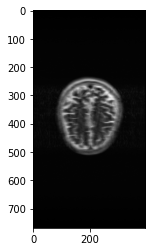

In [4]:
# Pick a slice
X_raw = combine_all_coils(volume_kspace,8)
plt.imshow(np.abs(X_raw), cmap='gray')

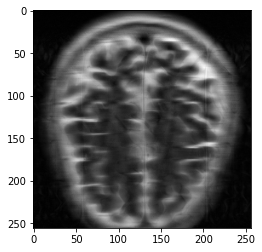

In [5]:
# Resize X for processing
X = resize_scan(X_raw)
plt.imshow(np.abs(X), cmap='gray')

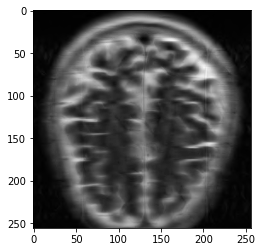

In [6]:
# k-encode and reconstruct
X_encode = k_encode(10000,X)
X_reconstruct = decode(X_encode)
plt.imshow(np.abs(X_reconstruct), cmap='gray')

In [7]:
# Let's try a bunch of k values, and determine loss for each
N = 3000 #256*256
K = np.arange(1, N, 10)
error = np.zeros(len(K))
ii = 0
for k in K:
    print('K: '+str(k)+' of '+str(N))
    error[ii] = evaluate_k(k,X)
    ii+=1


K: 1 of 3000
K: 11 of 3000
K: 21 of 3000
K: 31 of 3000
K: 41 of 3000
K: 51 of 3000
K: 61 of 3000
K: 71 of 3000
K: 81 of 3000
K: 91 of 3000
K: 101 of 3000
K: 111 of 3000
K: 121 of 3000
K: 131 of 3000
K: 141 of 3000
K: 151 of 3000
K: 161 of 3000
K: 171 of 3000
K: 181 of 3000
K: 191 of 3000
K: 201 of 3000
K: 211 of 3000
K: 221 of 3000
K: 231 of 3000
K: 241 of 3000
K: 251 of 3000
K: 261 of 3000
K: 271 of 3000
K: 281 of 3000
K: 291 of 3000
K: 301 of 3000
K: 311 of 3000
K: 321 of 3000
K: 331 of 3000
K: 341 of 3000
K: 351 of 3000
K: 361 of 3000
K: 371 of 3000
K: 381 of 3000
K: 391 of 3000
K: 401 of 3000
K: 411 of 3000
K: 421 of 3000
K: 431 of 3000
K: 441 of 3000
K: 451 of 3000
K: 461 of 3000
K: 471 of 3000
K: 481 of 3000
K: 491 of 3000
K: 501 of 3000
K: 511 of 3000
K: 521 of 3000
K: 531 of 3000
K: 541 of 3000
K: 551 of 3000
K: 561 of 3000
K: 571 of 3000
K: 581 of 3000
K: 591 of 3000
K: 601 of 3000
K: 611 of 3000
K: 621 of 3000
K: 631 of 3000
K: 641 of 3000
K: 651 of 3000
K: 661 of 3000
K: 671

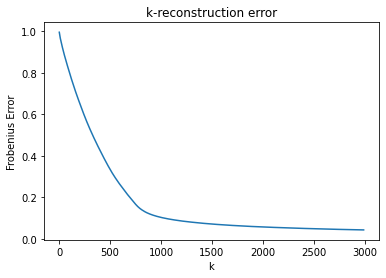

In [8]:
plt.plot(K, error)
plt.xlabel('k')
plt.ylabel('Frobenius Error')
plt.title('k-reconstruction error')
plt.show()

In [9]:
# Find approximation of error ~ 0.05
low = 0
high = 256*256
tolerance = 0.00001

approximate_k = binary_search(low=low, high=high, accuracy=.95, tolerance=tolerance,X=X)



print("k to achieve ~0.05 error is "+str(approximate_k))
print("True error is "+str(evaluate_k(approximate_k, X)))

k to achieve ~0.05 error is 2464
True error is 0.050020423


In [10]:
# Compare against the jpeg compressed image
matplotlib.image.imsave('X.jpg', X)
image = Image.open('X.jpg').convert('L')
# convert image to numpy array
X_jpeg = np.asarray(image.getdata()).reshape(image.size)
X_jpeg = X_jpeg*np.max(X)/255
jpeg_error = frob_error(X_jpeg,X)
print(jpeg_error)

0.26306849815374655


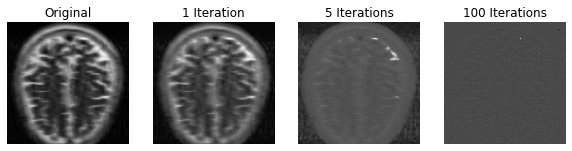

In [21]:
# Illustrating how bad jpeg is, here's perfoming it 3x recursively
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
fig.set_size_inches(10, 5)

X_recursive = X
ax1.imshow(np.abs(X_recursive), cmap='gray')
ax1.set_title('Original')
ax1.set_axis_off()
for ii in range(1):
    X_recursive = to_jpeg(X_recursive,X)
    ax2.imshow(np.abs(X_recursive), cmap='gray')
    ax2.set_title('1 Iteration')
    ax2.set_axis_off()
for ii in range(5):
    X_recursive = to_jpeg(X_recursive,X)
    ax3.imshow(np.abs(X_recursive), cmap='gray')
    ax3.set_title('5 Iterations')
    ax3.set_axis_off()
for ii in range(100):
    X_recursive = to_jpeg(X_recursive,X)
    ax4.imshow(np.abs(X_recursive), cmap='gray')
    ax4.set_title('100 Iterations')
    ax4.set_axis_off()

fig.savefig('../images/jpeg_recursion.png', dpi=100)

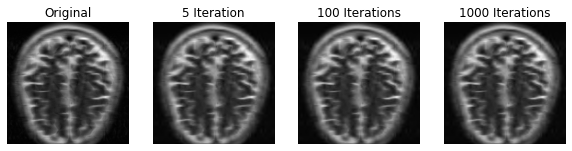

In [22]:
# Compare to how wavelet reconstruction looks
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
fig.set_size_inches(10, 5)

X_recursive = X
ax1.imshow(np.abs(X_recursive), cmap='gray')
ax1.set_title('Original')
ax1.set_axis_off()
for ii in range(1):
    X_encode = k_encode(3000,X_recursive)
    X_recursive = decode(X_encode)
    ax2.imshow(np.abs(X_recursive), cmap='gray')
    ax2.set_title('5 Iteration')
    ax2.set_axis_off()
for ii in range(5):
    X_encode = k_encode(3000,X_recursive)
    X_recursive = decode(X_encode)
    ax3.imshow(np.abs(X_recursive), cmap='gray')
    ax3.set_title('100 Iterations')
    ax3.set_axis_off()
for ii in range(100):
    X_encode = k_encode(3000,X_recursive)
    X_recursive = decode(X_encode)
    ax4.imshow(np.abs(X_recursive), cmap='gray')
    ax4.set_title('1000 Iterations')
    ax4.set_axis_off()

fig.savefig('../images/k_wavelet_recursion.png', dpi=100)